In [11]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Imagenes_confocal/Rata/C071112/'
nombre_foto = 'c3ack009'
x_calibracion = 4.5

In [15]:
import numpy as np                # funciones numéricas (arrays, matrices, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
%matplotlib inline
import cv2
import pandas as pd
import  csv


if __name__ == '__main__' :
# Read image
    imag = cv2.imread(path + nombre_foto + ".tif")

    if imag is None:
        print("Check file path")
    else:
         # Select ROI
        fromCenter = False
        showCrosshair = False
        r = cv2.selectROI(imag, fromCenter, showCrosshair)

        # Crop image
        imCrop = imag[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        up = int(r[1])
        down = int(r[1]+r[3])
        left = int(r[0])
        right = int(r[0]+r[2])
        
        # Display cropped image
        cv2.imshow("Image", imCrop)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# #########################
# #- Creating a log file -#
# log_path = path + 'logfile.txt'

# with open(log_path, 'a') as my_file:
#     my_file.write('selected area pict: '+ nombre_foto + '\n' +'up: ' + str(up) + '\n'+'down: ' + str(down) + '\n'+'left: ' + str(left) + '\n'+'right: ' + str(right) + '\n')

In [3]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

def f(brightness, contrast):
    img = np.int16(imCrop)
    img = img * (contrast/127+1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    plt.imshow(img)
    plt.show()
    return img

img_bc = interactive(f, brightness=100, contrast=100)
display (img_bc)

interactive(children=(IntSlider(value=100, description='brightness', max=300, min=-100), IntSlider(value=100, …

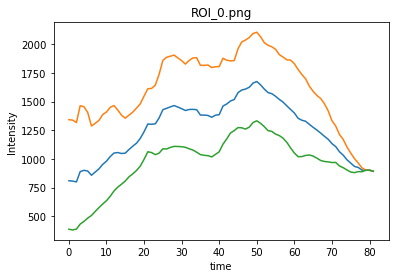

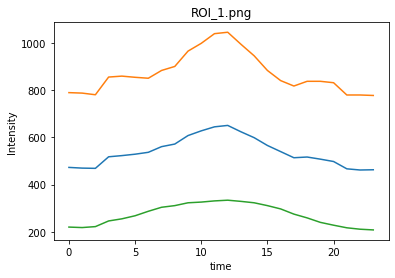

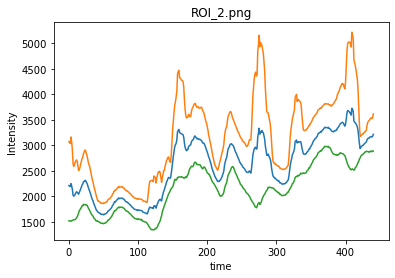

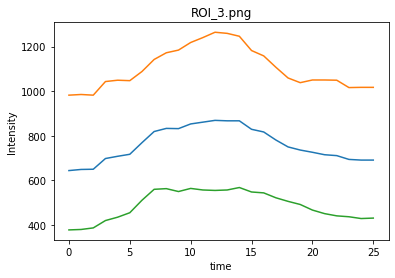

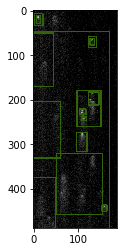

In [7]:
import cv2
import numpy as np
from PIL import Image

img = img_bc.result
original = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 20, 200, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and filter for ROI
image_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img, (x, y), (x + w, y + h), (50,100,5), 2)
    ROI = original[y:y+h, x:x+w]
    ROI_f = cv2.bilateralFilter(ROI,20,300,300)
#     cv2.imwrite("ROI_{}.png".format(image_number), ROI)
    SI = Image.fromarray(ROI_f.astype(np.uint8))
    img_row_sum = np.sum(SI,axis=1).tolist()
    #gráfico de histograma
    plt.plot(img_row_sum)
    plt.title("ROI_{}.png".format(image_number))
    plt.xlabel("time")
    plt.ylabel("Intensity")
    plt.show()
    image_number += 1

plt.imshow(img)
plt.show()

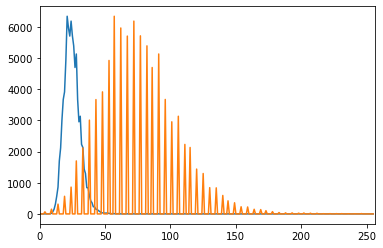

alpha 4.811320754716981
beta -43.30188679245283


In [25]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 750

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

image = cv2.imread(path + nombre_foto + ".tif")
auto_result, alpha, beta = automatic_brightness_and_contrast(imCrop)
print('alpha', alpha)
print('beta', beta)
cv2.imshow('auto_result', auto_result)
cv2.imwrite('auto_result.png', auto_result)
cv2.imshow('image', imCrop)
cv2.waitKey()
cv2.destroyAllWindows()

201 214 229 245


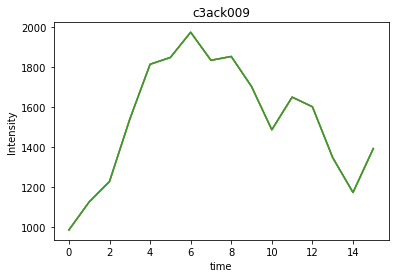

142 153 221 232


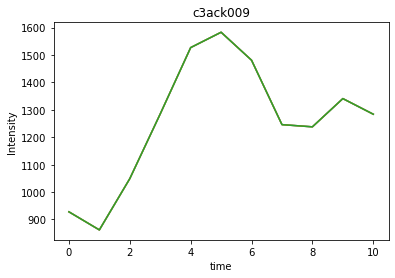

147 161 133 142


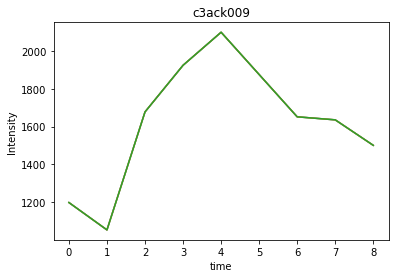

112 125 127 139


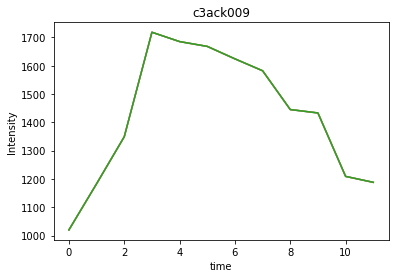

202 218 81 93


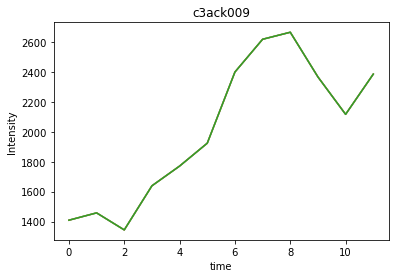

105 118 78 90


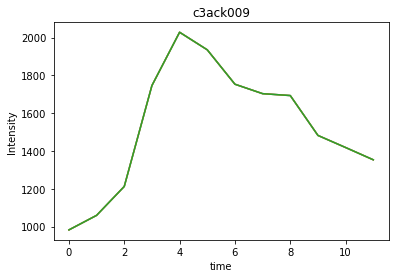

In [26]:
import cv2
import numpy as np
from PIL import Image

img = auto_result
original = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 50)
canny = cv2.Canny(blurred, 150, 400, 30)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and filter for ROI
image_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,0), 2)
    print (x, x+w, y, y+h)
    ROI = original[y:y+h, x:x+w]
    x_data = np.asarray(range(x,x+w),dtype=np.float64)
    list_img_row = []
    #análisis de cada franja
    SI = Image.fromarray(ROI.astype(np.uint8))
    img_row_sum = np.sum(SI,axis=1).tolist() #lista de datos del histograma
    list_img_row.append (img_row_sum)
    #gráfico de histograma
    plt.plot(img_row_sum)
    plt.title(nombre_foto)
    plt.xlabel("time")
    plt.ylabel("Intensity")
    plt.savefig('img_row_sum')
    plt.show()
#     cv2.imwrite("ROI_{}.png".format(image_number), ROI)
    image_number += 1

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()